A few points of advice leading into next week:

- Nail down that problem statement 
- Define key metrics
- Show your key metrics in each milestone
- Fully explore the relevant details of your EDA but feel free to leave out anything that’s not important
- Be concise (remove any extraneous features from plots if they are note relevant talking points)
- Be prepared to explain the reasoning behind any models you’ve chosen or sampling methods used
- Conclude with your key metrics, problem statement, and any recommendation

Lastly, if your main notebook for all your technical details is becoming huge, consider creating a notebook that describes all the milestones, their findings, and then link to any other notebooks containing more detail.  It’s good idea to make your project navigable.  Make it easy for anyone to evaluate your work by allowing them to get the big picture, then drill in where they may want.

I know not every project will be able to fit into this workflow, but do try to fit it to this ideal as close as possible.  We realize not every project will fit these requirements %100 so we’re flexible.  It is important to backup your reasoning for any decisions so this is a great opportunity to demonstrate and practice your analysis skills.

Here are some guidelines to help frame your technical presentation:
https://git.generalassemb.ly/dsi-plus-2/dsi-plus-home/wiki/Editing-Capstone-Part-2:-Findings-and-Technical-Report

Build a recommender
- Typical problem is that what’s popular gets recommended the most
- Could penalize similarity of popular tracks
- Could emphasize sonic quality
- Base it on active users or not
- Could exclude users listening to popular stuff
- Collaborative rules + heuristic filter.  If you like reggae and want to recommend non-reggae

- Hit ratio - build recommendations based on a set number of user tracks (say the 10 most similar users) and only show ones the current users haven’t seen, test within this.  Then a holdout set might be future user tracks.  
- Did they listen to the track in the future based on that rec?

Start with what the most common users are using.  Do they listen to pop, or what other genres? 
What other listening habits do we see?  Then define where you want to go

text cleaning > Tifdf > SVD > Cosine Similarity


    In pearson correlation, the mean which subtracted is about the particular item itself (ratings from all users), mean(Ri)
    In adjusted cosine correlation, the mean is about the particular user (ratings to all items), mean(Ru)

need to tfidf my genres list and build a matrix for each user

### problems converting each artist into a matrix of genres
- original intent was to take each genre that had 100 votes and each genre that made up more than 5% of the genre votes for an artist
    - this ended up with a 150000 x 11000 matrix (artists x genres) which I could not manage in docker
    
- convert to sparse matrix (doesn't seem to save space)



In [3]:
# from sklearn.preprocessing import StandardScaler
import pandas as pd, numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
import pickle
# from time import sleep
from tqdm import tqdm
import seaborn as sns
import sqlite3
con = sqlite3.connect("lastfm_1k_sql")
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

In [4]:
# artist_genre_percent = pickle.load( open( "artist_genre_percent", "rb" ) ) 
# artist_genre_percent_filtered = pickle.load( open( "artist_genre_percent_filtered", "rb" ) ) 
# pickle.dump(artist_genre_percent_filtered, open('artist_genre_percent_filtered', "wb" ) )

### tfidf - done manually to retain scale values

In [5]:
# build a unit vector genre list
def select_unique_genres():
    sql = ("SELECT DISTINCT genre "
           "FROM artist_genre_percent_sql "
           )

    genre_matrix = pd.read_sql(sql, con=con)
    return pd.DataFrame(genre_matrix, index=genre_matrix['genre']).T

# select n random userids
def select_random_users(num_users):
    sql = ("SELECT DISTINCT usersha1 "
           "FROM lastfm_360k_sql "
           "ORDER BY Random() "
           "LIMIT'{0}'").format(num_users)

    user_list = pd.read_sql(sql, con=con)
    return user_list

# pull the full unique genre_matrix
# genre_matrix = select_unique_genres()

# pull the filtered test user/genre matrix
# filtered_genre_matrix = pickle.load( open( "filtered_genre_matrix", "rb" ) ) 

In [6]:
def build_user_vector(usersha, test_values=False, scale_by_plays=True, full_matrix=False):

    # pull all artists/plays for a given user
    sql = ("SELECT lastfm_360k_sql.usersha1, lastfm_360k_sql.artmbid, lastfm_360k_sql.artname, lastfm_360k_sql.plays "
           "FROM lastfm_360k_sql "
           "WHERE lastfm_360k_sql.usersha1 = '{0}' ").format(usersha)
    user1 = pd.read_sql(sql, con=con)
    
    # build string of artist ids corresponding to the user to query sql
    new_str = ''
    for ids in list(user1['artmbid']):
        new_str += 'id = "{0}" or '.format(ids)
        
    # pull the user's artist/genre mix.  sql code could be used to build in a user-defined limit here
    sql = ("SELECT artist_genre_percent_sql.artmbid as id, "
           "artist_genre_percent_sql.genre, "
           "artist_genre_percent_sql.genre_percent "
           "FROM artist_genre_percent_sql "
           "WHERE {0}").format(new_str[:-4])
    artist_genre = pd.read_sql(sql, con=con)
    artist_genre.rename(columns={'id':'artmbid'}, inplace=True)
    
    # pivot the user's matrix 
    joined_matrix = artist_genre.pivot_table(values='genre_percent',
                                                    index='artmbid', 
                                                    columns='genre', 
                                                    dropna=False)
    
    # scale the user's genre preference by # of plays of that artist
    if scale_by_plays:
        for artmbid1 in user1.artmbid.values:
            num_plays = user1.plays[user1.artmbid == artmbid1].values
            try:
                joined_matrix.loc[artmbid1] *= num_plays
            except KeyError:
                pass
            
    # returns the actual non-null values in the matrix, summed by artist, as an error check
    if test_values:
        joined_matrix['e'] = joined_matrix.sum(axis=1)
        return joined_matrix['e'][~joined_matrix['e'].isnull()]
    
    if full_matrix:
        return joined_matrix
    else:
        # return a dictionary with total genre profile of the user, indexed by usersha1
        joined_matrix.loc[usersha] = joined_matrix.sum()
        user_vector = joined_matrix.loc[usersha]
        return user_vector.to_dict()
    

In [7]:
# build genre taste matrix for specified number of random users

def build_taste_matrix(num_users, limited=False):
    
    user_list_of_dicts = []
    index_list = []
    
    how_many = select_random_users(num_users)
    
    if not limited:
        for i in tqdm(range(len(how_many))):
            useri_vector = build_user_vector(how_many['usersha1'][i])
            user_list_of_dicts.append(useri_vector)
            index_list.append(how_many['usersha1'][i])
    else:
        for i in tqdm(range(len(how_many))):
            useri_vector = build_user_vector_limited(how_many['usersha1'][i])
            user_list_of_dicts.append(useri_vector)
            index_list.append(how_many['usersha1'][i])

    return pd.DataFrame(user_list_of_dicts, index=index_list)

### capture 100 random users to build our user-genre-profile matrix for cosine similarity

In [8]:
# no_accounting = build_taste_matrix(500)
# pickle.dump(no_accounting, open('no_accounting', "wb" ) )

no_accounting = pickle.load( open( "no_accounting", "rb" ) ) 
no_accounting_for_taste = no_accounting.fillna(0)
no_accounting_for_taste.index.name = 'usersha1'

In [9]:
no_accounting_for_taste.head()

,not ripped,psychedelic rock,'00s,'70s,'80s,'90s,-artist,-listen,0 play yet,00's,...,zup,zwing,zxzw,zxzw 2007,zxzw 2009,zxzw2009,zydeco,zz,zzzzzzzzzzzzz,österreich
usersha1,,,,,,,,,,,,,,,,,,,,,
bb1f61e8fccddd13b341563189e9a708d6b85e13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bb887c518d10546fa6cbafe4b826af311b2cbdbb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.430155,...,0.0,0.0,1.094505,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9b6ae0ec405278aaf14b79479e1b17880e0aaab8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c10000349f08b8b8c4136ff1a53af212846ecfc3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3400ffa0cb7f40949b461069b38b25b771f79564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# mean number of genres per user
num_genres = (10648 - no_accounting.isnull().sum(axis=1))

# std in number of genres per user

display(num_genres.mean())
display(num_genres.std())

num_genres.plot.hist()
plt.xlabel('Number of Genres')

517.88599999999997

In [9]:
# std in number of genres per user
num_genres.std()

125.90776996307316

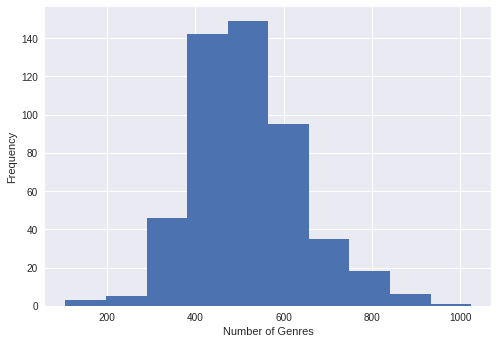

In [10]:
num_genres.plot.hist()
plt.xlabel('Number of Genres')

### finally, the actual similarity matrix

In [20]:
users_sim = pd.DataFrame(cosine_similarity(no_accounting_for_taste, no_accounting_for_taste), columns=no_accounting_for_taste.index, index=no_accounting_for_taste.index)
display(users_sim.head())

usersha1,bb1f61e8fccddd13b341563189e9a708d6b85e13,bb887c518d10546fa6cbafe4b826af311b2cbdbb,9b6ae0ec405278aaf14b79479e1b17880e0aaab8,c10000349f08b8b8c4136ff1a53af212846ecfc3,3400ffa0cb7f40949b461069b38b25b771f79564,89fd0b6bfcf9e7ab4fbc89ff2425f260bdf6134d,de442dc920a2e656977b0b8eb5497e6070f72ab8,82c9e036a998209ee0b1ffd60441021e9e157253,c1394df26be84dc4b5d05707e4ccb5b8c748de00,75f7da51d3dfecff55a49e08fb976c969e156a1a,...,8b922e55d162bc4e37699e9381146af968473b9c,d9e3c977e51f5ad7009ca66f29d6201829518609,9c2a40cfedbac2e4da34f3b7cb8b1e616d32a47f,739c2514fd8a27076121f09524f2e9044170710f,6766c89c2a271720e3ac57e1191fd54ab61859de,f6a417b06102f3407f46aa40db6570b12e4b2102,a9ce7cce78b59cbe4aeceb5ae80994576a7adc0d,9c229993dac5c6d9387de8b88067c31227d87e9c,0e948a549e1d5d68d47c41858cc6c1e3ea83b290,33ca636574bb480f076a2ba3039e877dfd2054a4
usersha1,,,,,,,,,,,,,,,,,,,,,
bb1f61e8fccddd13b341563189e9a708d6b85e13,1.000000,0.189972,0.102310,0.219403,0.014269,0.285383,0.005933,0.048960,0.421646,0.093098,...,0.328486,0.064209,0.111353,0.031172,0.005774,0.354487,0.174669,0.069132,0.010289,0.061783
bb887c518d10546fa6cbafe4b826af311b2cbdbb,0.189972,1.000000,0.215840,0.894918,0.046565,0.218527,0.040394,0.118884,0.432702,0.199873,...,0.369617,0.173621,0.071712,0.196387,0.006851,0.723485,0.262265,0.118637,0.080458,0.116165
9b6ae0ec405278aaf14b79479e1b17880e0aaab8,0.102310,0.215840,1.000000,0.119089,0.056800,0.131763,0.008038,0.030963,0.228929,0.193772,...,0.121333,0.035830,0.267195,0.018978,0.007354,0.196426,0.065592,0.044358,0.010944,0.175574
c10000349f08b8b8c4136ff1a53af212846ecfc3,0.219403,0.894918,0.119089,1.000000,0.056154,0.306596,0.076130,0.114022,0.440716,0.194211,...,0.389086,0.176376,0.041092,0.192575,0.007426,0.736324,0.313764,0.179366,0.077615,0.119118
3400ffa0cb7f40949b461069b38b25b771f79564,0.014269,0.046565,0.056800,0.056154,1.000000,0.031406,0.141316,0.355685,0.444502,0.461425,...,0.059249,0.324819,0.005122,0.145215,0.616420,0.049470,0.121757,0.032655,0.084198,0.650715


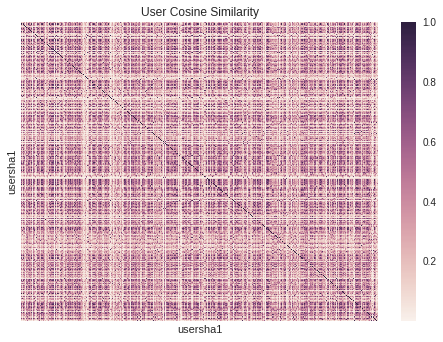

In [12]:
sns.heatmap(users_sim, annot=False, xticklabels=False, yticklabels=False)
plt.title("User Cosine Similarity")

### going forward, we'll use one user sampled randomly to test our model

In [10]:
# sample 1 user from our list
random_user = no_accounting_for_taste.sample()
random_usersha1 = random_user.index[0]
display("our user", random_usersha1)

'our user'

'c6e2753ec296e00f5b825b76dde6a01bfb6dad84'

In [18]:
# our user's vector and top genres
no_accounting_for_taste.loc[random_usersha1][no_accounting_for_taste.loc[random_usersha1] > 0].sort_values(ascending=False).head(30)

Hip-Hop                1430.970873
rap                    1407.278166
hip hop                 818.533251
Deutschrap              568.480507
german                  352.346735
latin                   190.602572
french                  183.482866
cuban                   163.454276
reggae                  135.550537
Gangsta Rap             132.253190
rap francais            126.048433
rnb                     117.985368
german hiphop           103.315784
pop                      98.564433
hiphop                   97.999569
french rap               91.454396
german rap               89.725349
dancehall                79.695597
Reggaeton                77.588570
deutsch                  76.354654
underground hip-hop      73.888491
alternative              66.268590
Berlin                   58.544962
new york                 57.318772
electronic               56.829473
comedy                   56.524996
Dirty South              55.664135
dance                    55.296620
french hip-hop      

In [21]:
# recommendations for our user.  based on test of multiple users, this just seems to reflect the overall genre prefs
# of the whole group.  not so useful
user_recs = no_accounting_for_taste.T * users_sim[random_usersha1]
user_recs.T.mean().sort_values(ascending=False)

Hip-Hop                          8.858038e+01
rap                              5.630992e+01
rock                             5.482800e+01
alternative                      3.895122e+01
hip hop                          3.518037e+01
indie                            3.497437e+01
electronic                       2.748923e+01
pop                              2.471792e+01
soul                             2.098762e+01
alternative rock                 2.033769e+01
rnb                              1.987635e+01
female vocalists                 1.755483e+01
indie rock                       1.512681e+01
singer-songwriter                1.470373e+01
underground hip-hop              1.419361e+01
punk                             1.347503e+01
jazz                             1.322543e+01
classic rock                     1.308357e+01
metal                            1.251764e+01
reggae                           1.215749e+01
experimental                     1.013463e+01
punk rock                        9

In [22]:
top_n_users = lambda usersha1: users_sim.query("usersha1 == '%s'" % usersha1).T.sort_values(usersha1, ascending=False)

new_matrix = (no_accounting_for_taste.T[no_accounting_for_taste.query("index == '{}'".format(random_usersha1)).any(0)]).dot(top_n_users(random_usersha1))
new_matrix.T

,00s,2000s,2008,50 Cent,6 stars,7 stars,80s,90s,90s hip-hop,ATL,...,want to see live,weed,west coast,west coast hip hop,west coast hip-hop,westcoast,white rap,world,wu,wu-tang
usersha1,,,,,,,,,,,,,,,,,,,,,
c6e2753ec296e00f5b825b76dde6a01bfb6dad84,1414.508865,21.430149,2.390801,119.371283,11.905032,20.688445,3036.625382,2281.577926,6.721235,63.157931,...,50.54372,19.634468,1397.586951,71.555339,196.264879,79.973189,16.196835,588.562595,7.306416,296.351148


In [23]:

# show the top 10 similar listeners
display("Top Similar Listeners", top_n_users(random_usersha1)[:10])

# common genres is nice, but not so useful.  weights not accounted for, and includes too many
display("Common Genres", no_accounting_for_taste.T[no_accounting_for_taste.query("index == '{}'".format(random_usersha1)).any(0)])

'Top Similar Listeners'

usersha1,c6e2753ec296e00f5b825b76dde6a01bfb6dad84
usersha1,
c6e2753ec296e00f5b825b76dde6a01bfb6dad84,1.000000
6ca5e5f6fe8dbb1e197cededd009c62a2bc006d3,0.912033
643a8d0f6e6d4963215cd937344d3ff015867c99,0.909134
486c1140218c91cc05d8409eec20ab90cc05b840,0.906878
a626f1bc9d6ca03c87fb06eb67391333d0a8bf04,0.902945
1a679ae4005f46eb7f4c4b23d0a301adaeab3bbd,0.899694
6766c89c2a271720e3ac57e1191fd54ab61859de,0.879769
504784c2830133b421157020007bc68409aead27,0.875286
430b1a9cfe4b4717994fb8546fb7d979ee52c408,0.854056


'Common Genres'

usersha1,bb1f61e8fccddd13b341563189e9a708d6b85e13,bb887c518d10546fa6cbafe4b826af311b2cbdbb,9b6ae0ec405278aaf14b79479e1b17880e0aaab8,c10000349f08b8b8c4136ff1a53af212846ecfc3,3400ffa0cb7f40949b461069b38b25b771f79564,89fd0b6bfcf9e7ab4fbc89ff2425f260bdf6134d,de442dc920a2e656977b0b8eb5497e6070f72ab8,82c9e036a998209ee0b1ffd60441021e9e157253,c1394df26be84dc4b5d05707e4ccb5b8c748de00,75f7da51d3dfecff55a49e08fb976c969e156a1a,...,8b922e55d162bc4e37699e9381146af968473b9c,d9e3c977e51f5ad7009ca66f29d6201829518609,9c2a40cfedbac2e4da34f3b7cb8b1e616d32a47f,739c2514fd8a27076121f09524f2e9044170710f,6766c89c2a271720e3ac57e1191fd54ab61859de,f6a417b06102f3407f46aa40db6570b12e4b2102,a9ce7cce78b59cbe4aeceb5ae80994576a7adc0d,9c229993dac5c6d9387de8b88067c31227d87e9c,0e948a549e1d5d68d47c41858cc6c1e3ea83b290,33ca636574bb480f076a2ba3039e877dfd2054a4
00s,3.358399,68.240669,14.377872,46.809657,16.638866,11.913439,0.077289,132.504168,9.712106,0.244521,...,3.918733,5.102268,0.078125,4.323847,5.406921,4.583428,18.045224,0.980178,0.520581,4.017224
2000s,0.000000,2.085353,7.770574,1.319575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021186,0.000000,0.000000
2008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50 Cent,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.716145,0.000000,0.000000,0.000000,0.000000,0.000000
6 stars,0.000000,1.565762,6.066188,0.000000,3.744395,0.323394,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.078872,0.000000,0.024096,0.000000,0.000000,0.008282,0.000000,0.000000
7 stars,0.000000,0.000000,19.606261,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.079764,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.416621
80s,7.087061,17.938971,29.529418,66.224469,67.092080,71.862616,0.091217,189.933564,3.836891,1.030541,...,51.599987,10.992303,0.041879,5.378029,0.787373,1.071788,11.458156,1.020621,0.335608,1.317181
90s,4.592838,15.196953,5.030836,13.087377,148.609234,26.585616,0.096657,178.129183,12.850542,0.333979,...,37.760406,30.374403,0.092515,3.213562,42.048486,4.120063,23.017422,0.877802,3.515762,5.402599
90s hip-hop,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ATL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.102974,4.374809,0.010554,...,0.000000,0.000000,0.000000,0.000000,2.266091,0.000000,0.000000,0.000000,0.000000,0.000000


In [24]:
sim_user = users_sim[random_usersha1]
user_mask = no_accounting_for_taste.loc[random_usersha1] < 0.1

user_genre_matrix = no_accounting_for_taste.loc[:, user_mask] # remove genres user has listened to
user_genre_matrix = user_genre_matrix.multiply(sim_user, axis='rows') # weight genres by user similarity 
user_genre_matrix = user_genre_matrix.drop(random_usersha1, axis = 0) # drop user from own recs
user_recommond = user_genre_matrix.sum().sort_values(ascending=False) # sum genre totals and order
user_recommond

post-hardcore                    3575.499193
swedish                          2989.941281
screamo                          2338.112878
blues                            2108.010440
post-rock                        1823.439569
idm                              1797.434436
downtempo                        1671.949964
Progressive metal                1636.037431
Canadian                         1617.968578
polish                           1428.622751
Grunge                           1420.264002
Power metal                      1289.929375
japanese                         1267.957392
70s                              1233.482780
Classical                        1206.613689
60s                              1185.129531
Melodic Death Metal              1108.843165
piano                            1108.272857
Gothic Metal                      999.348318
finnish                           901.318398
emocore                           877.878209
Stoner Rock                       840.642834
country   

### compare with SVD to see how it affects our results
- since we're dealing with very long, sparse matrices of genres, *****

In [25]:
# reducing from 10,468 genres down to 40 components still yields 97% variance explanation
# clearly, there are many genres that overlap, and this should reduce some of that dimensionality

n_components = 40
SVD = TruncatedSVD(n_components)
component_names = ["component_"+str(i+1) for i in range(n_components)]
svd_matrix = SVD.fit_transform(no_accounting_for_taste)
sum(SVD.explained_variance_ratio_)

0.97120894014773496

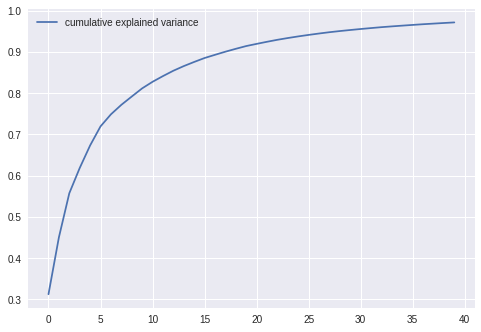

In [26]:
plt.plot(range(40), np.cumsum(SVD.explained_variance_ratio_), label='cumulative explained variance')
plt.legend()

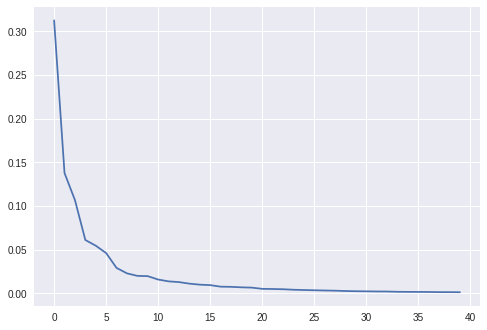

In [27]:
plt.plot(SVD.explained_variance_ratio_)

### what do these components look like?

In [28]:
feature_names = no_accounting_for_taste.columns

# the threshold here is in the SVD matrix for contribution amount, running -1 -> 1.  we're selecting for highly
# positive or highly negative components to see what's important in defining a component
def view_components(comp_num, threshold):
    i_components = []
    full_components = [(coef, feat) for coef, feat in zip(SVD.components_[comp_num], feature_names)]
    for i,j in full_components:
        if i > threshold or i < -threshold:
            i_components.append((i,j))
    component = pd.DataFrame(i_components, columns=['contribution','genre'])
    return component.sort_values('contribution', ascending=False)

In [29]:
component_25 = view_components(25, 0.15)
component_25

,contribution,genre
6,0.353495,japanese
2,0.228704,black metal
8,0.200794,soul
5,0.165966,j-pop
3,0.159373,emo
1,0.155575,J-rock
4,-0.178514,finnish
0,-0.205801,Classical
7,-0.235072,singer-songwriter


### now pull the 10 most similar users and identify genres in common to all but our random user

In [30]:
# set threshold for eliminating "bad" genres.  this is essentially our hyperparameter that filters for the 
# weighted number we've been carrying forward on our matrices, ranging from 0 to hundreds
# a threshold of 50 could mean 50 listens to an artist with 1 tag, or 100 listens to an artist with 2 equal tags, etc
threshold = 30

# return all genres from a given user with the given threshold, written specifically for df.apply
def get_genres(row):
    genre_list = []
    for column in no_accounting_for_taste.columns:
        if no_accounting_for_taste.loc[row['userid']][column] > threshold:
            genre_list.append(column)
    return genre_list

# return all genres from a given user that they ever listened to
def get_all_genres(userid):
    genre_list = []
    for column in no_accounting_for_taste.columns:
        if no_accounting_for_taste.loc[userid][column] > 0:
            genre_list.append(column)
    return genre_list

In [31]:
# look up a userid by index
def user_lookup(user_index):    
    return no_accounting_for_taste.iloc[user_index].name

# jaccard function to compare a given user to our target user, written specifically for df.apply
def jaccard(row):
    a = set(results_matrix.user_genres[results_matrix.index[0]])
    b = set(results_matrix.user_genres[row.name])
    numerator = a.intersection(b)
    denominator = a.union(b)
    diff_items = len(b.difference(a))
    return len(numerator)/len(denominator), diff_items

In [32]:
# transform the user's profile to the SVD and df our full user matrix
svd_user = SVD.transform(random_user) 
svd_df = pd.DataFrame(svd_matrix)

# add a cosine similarity column between the random user and the full user list
# at the moment this similarity takes into account ALL genres, even low-value ones. those are filtered out after 
# similarity is calculated.  this likely affects who is similar, but only marginally
svd_df['cosine_sim'] = cosine_similarity(svd_df, svd_user) 

# pull the 10 most similar users.  note: 0 = our user
results_matrix = svd_df[['cosine_sim']].sort_values('cosine_sim', ascending=False)[0:10] 

# look up userids, add them, and append a list of their genres
results_matrix['userid'] = results_matrix.index
results_matrix['userid'] = results_matrix['userid'].apply(user_lookup)
results_matrix['user_genres'] = results_matrix.apply(get_genres, axis=1)

# calculate the jaccard score to compare our random user to each other user
results_matrix['jaccard'] = results_matrix.apply(jaccard, axis=1)
results_matrix

,cosine_sim,userid,user_genres,jaccard
250,1.000000,c6e2753ec296e00f5b825b76dde6a01bfb6dad84,"[Berlin, Crunk, Deutschrap, Dirty South, Gangs...","(1.0, 0)"
494,0.985854,6766c89c2a271720e3ac57e1191fd54ab61859de,"[90s, Bay Area, California, Dirty South, East ...","(0.16981132075471697, 10)"
125,0.981523,643a8d0f6e6d4963215cd937344d3ff015867c99,"[90s, Aftermath, Dirty South, East Coast, Gang...","(0.20588235294117646, 25)"
298,0.978909,a626f1bc9d6ca03c87fb06eb67391333d0a8bf04,"[80s, 90s, California, Dirty South, East Coast...","(0.26865671641791045, 24)"
297,0.973049,1a679ae4005f46eb7f4c4b23d0a301adaeab3bbd,"[00s, 50 Cent, 90s, Brooklyn, California, Crap...","(0.1981981981981982, 68)"
362,0.971420,6ca5e5f6fe8dbb1e197cededd009c62a2bc006d3,"[Gangsta Rap, Hip-Hop, female vocalists, hip h...","(0.16279069767441862, 0)"
240,0.970468,486c1140218c91cc05d8409eec20ab90cc05b840,"[00s, 70s, Canadian, Dirty South, Disco, East ...","(0.3064516129032258, 19)"
22,0.968107,504784c2830133b421157020007bc68409aead27,"[90s, Doom, East Coast, Eminem, Gangsta Rap, H...","(0.26785714285714285, 13)"
93,0.956411,430b1a9cfe4b4717994fb8546fb7d979ee52c408,"[Dirty South, Hip-Hop, Jazz Hop, Lil Wayne, St...","(0.21666666666666667, 17)"
168,0.947288,89ce63de59052028b36d2a7b74476892813b39d1,"[Hip-Hop, Neo-Soul, Polski Hip Hop, alternativ...","(0.2, 7)"


In [33]:
# compare this to our list of top users from above based on vanilla cosine similarity.  
# high variance.  sometimes these are identical, other times very dissimilar.  
# SVD does something, but what?

"Top Similar Listeners", top_n_users("d75df094b72713120c296b5ada88328927660304")[:10]

('Top Similar Listeners',
 usersha1                                  d75df094b72713120c296b5ada88328927660304
 usersha1                                                                          
 d75df094b72713120c296b5ada88328927660304                                  1.000000
 e486e06dc43cd839f1e8a727d63f6e282f55cf4b                                  0.833462
 41907ac75c96f5ed1c9e38d3728fa0284a22810f                                  0.784057
 29266da92e92c2702743ae3a00231fb8f764f95a                                  0.759285
 e1e95b7f0fabab7229448f8ac1595db2392d45cf                                  0.742374
 9d009a218d5455291e8167dfe04103b06b868efb                                  0.706163
 d02a3b33c5c946b070e0fa225e5829bc272ead26                                  0.702893
 63a524f9859f48f4a7899b33eb449c1c97c4699d                                  0.698561
 29b938219e2269319b1986b379181d32ae288b69                                  0.694012
 a241ac25364649106bbe8b473c180043f5b78041         

In [34]:
# to reduce variance, we can compare the other user curated lists to the entire random_user_list
# this should eliminate us recommending a genre to someone who has listened to it a little bit, below the threshold

# another hyperparameter to tune is whether we pull from the top 5, 10, etc.  too many risks wiping out everything

# pull the random user's full list, and everyone else in the top 5
random_user_full_list = set(get_all_genres(random_user.index[0]))
all_other_list = set(results_matrix['user_genres'][1:5].sum())

# all items appearing in our similar users' top lists and not in our random user's full list
diff_full_list = all_other_list.difference(random_user_full_list)

display( len(diff_full_list), diff_full_list )


# comparing filtered list to filtered list results in more junk in the rec list
random_user_list = set(results_matrix.user_genres[results_matrix.index[0]])
# diff_user_list = all_other_list.difference(random_user_list)
# display(len(diff_user_list), diff_user_list)


16

{'Bay Area',
 'Oakland',
 'REVOLUTIONARY',
 'Rasta',
 'Rave',
 'blues',
 'detroit',
 'dj',
 'jamaica',
 'juggalo',
 'new jersey',
 'norwegian',
 'post-hardcore',
 'rap hardcore',
 'screamo',
 'turntablism'}

In [35]:
len(all_other_list)

117

In [36]:
random_user_full_list

{'00s',
 '2000s',
 '2008',
 '50 Cent',
 '6 stars',
 '7 stars',
 '80s',
 '90s',
 '90s hip-hop',
 'ATL',
 'Afro-Cuban',
 'Afro-Cuban Jazz',
 'Aftermath',
 'Alta-tensao',
 'Anarcho',
 'Awesome',
 'Battlerap',
 'Beastie Boys',
 'Berlin',
 'Berlin Untergrund',
 'Black',
 'Bossa Nova',
 'Britney Spears',
 'Britrock',
 'Brooklyn',
 'California',
 'Chicano',
 'Chicano Rap',
 'Chillosophy',
 'Conscious Hip Hop',
 'Conscious Rap',
 'Crap',
 'Crunk',
 'Cypress Hill',
 'Dance-Trance',
 'Death Rap',
 'Deutsch Hiphop',
 'Deutsch Rap',
 'Deutscher Hip Hop',
 'Deutschrap',
 'Dirty South',
 'Dirty South rap',
 'Disco',
 'Dope',
 'Dreck',
 'Drum and bass',
 'Drum n Bass',
 'East Coast',
 'Electroclash',
 'Electronica and Dance',
 'Eminem',
 'Energetic',
 'Europe',
 'European Hip-Hop',
 'Exactly 2000 listeners',
 'Fox',
 'Français',
 'French hip hop',
 'Fueled by Ramen',
 'Fusion',
 'G-Unit',
 'G-funk',
 'Gangsta Rap',
 'Gangster Rap',
 'Garage Rock',
 'German hip hop',
 'Good Stuff',
 'Great Lyricists',

In [37]:
random_user_list

{'Berlin',
 'Crunk',
 'Deutschrap',
 'Dirty South',
 'Gangsta Rap',
 'German hip hop',
 'Hip-Hop',
 'Reggaeton',
 'Soundtrack',
 'alternative',
 'american',
 'comedy',
 'cuban',
 'dance',
 'dancehall',
 'deutsch',
 'east coast rap',
 'electronic',
 'female vocalists',
 'french',
 'french hip-hop',
 'french rap',
 'funny',
 'german',
 'german hip-hop',
 'german hiphop',
 'german rap',
 'hip hop',
 'hiphop',
 'indie',
 'jazz',
 'latin',
 'new york',
 'pop',
 'rap',
 'rap francais',
 'reggae',
 'rnb',
 'rock',
 'soul',
 'southern rap',
 'spanish',
 'underground hip-hop'}

### rating recs

In [38]:
ratings = pd.melt(no_accounting_for_taste.reset_index(), id_vars=["usersha1"], var_name="genre", value_name="weight")
ratings.head()

,usersha1,genre,weight
0,bb1f61e8fccddd13b341563189e9a708d6b85e13,not ripped,0.0
1,bb887c518d10546fa6cbafe4b826af311b2cbdbb,not ripped,0.0
2,9b6ae0ec405278aaf14b79479e1b17880e0aaab8,not ripped,0.0
3,c10000349f08b8b8c4136ff1a53af212846ecfc3,not ripped,0.0
4,3400ffa0cb7f40949b461069b38b25b771f79564,not ripped,0.0


In [39]:
nancy_sim = cosine_similarity(no_accounting_for_taste.query("index == '{}'".format(random_usersha1)), no_accounting_for_taste)
nancy_sim = pd.Series(nancy_sim[0], index=no_accounting_for_taste.index)
nancy_sim.head()

usersha1
bb1f61e8fccddd13b341563189e9a708d6b85e13    0.020300
bb887c518d10546fa6cbafe4b826af311b2cbdbb    0.043943
9b6ae0ec405278aaf14b79479e1b17880e0aaab8    0.020372
c10000349f08b8b8c4136ff1a53af212846ecfc3    0.045795
3400ffa0cb7f40949b461069b38b25b771f79564    0.649502
dtype: float64

In [40]:
ratings.loc[:, 'nancy_similarity'] = ratings['usersha1'].map(nancy_sim.get)
ratings.loc[:, 'nancy_est_rating'] = ratings['nancy_similarity'] * ratings['weight']
ratings

,usersha1,genre,weight,nancy_similarity,nancy_est_rating
0,bb1f61e8fccddd13b341563189e9a708d6b85e13,not ripped,0.0,0.020300,0.0
1,bb887c518d10546fa6cbafe4b826af311b2cbdbb,not ripped,0.0,0.043943,0.0
2,9b6ae0ec405278aaf14b79479e1b17880e0aaab8,not ripped,0.0,0.020372,0.0
3,c10000349f08b8b8c4136ff1a53af212846ecfc3,not ripped,0.0,0.045795,0.0
4,3400ffa0cb7f40949b461069b38b25b771f79564,not ripped,0.0,0.649502,0.0
5,89fd0b6bfcf9e7ab4fbc89ff2425f260bdf6134d,not ripped,0.0,0.031410,0.0
6,de442dc920a2e656977b0b8eb5497e6070f72ab8,not ripped,0.0,0.015798,0.0
7,82c9e036a998209ee0b1ffd60441021e9e157253,not ripped,0.0,0.501141,0.0
8,c1394df26be84dc4b5d05707e4ccb5b8c748de00,not ripped,0.0,0.564269,0.0
9,75f7da51d3dfecff55a49e08fb976c969e156a1a,not ripped,0.0,0.574209,0.0


In [41]:
ratings.groupby("genre").apply(lambda r: r['nancy_est_rating'].sum() / r['nancy_similarity'].sum()).sort_values(ascending=False)

# make sure to go through and filter out the ones she's seen, seems to be some in here?

genre
Hip-Hop                          7.012068e+02
rap                              4.457523e+02
rock                             4.340213e+02
alternative                      3.083399e+02
hip hop                          2.784896e+02
indie                            2.768589e+02
electronic                       2.176062e+02
pop                              1.956683e+02
soul                             1.661391e+02
alternative rock                 1.609942e+02
rnb                              1.573422e+02
female vocalists                 1.389650e+02
indie rock                       1.197446e+02
singer-songwriter                1.163955e+02
underground hip-hop              1.123573e+02
punk                             1.066690e+02
jazz                             1.046932e+02
classic rock                     1.035702e+02
metal                            9.909025e+01
reggae                           9.623934e+01
experimental                     8.022623e+01
punk rock                   

### problems
- the tags are still dirty.  the variance in names gets washed out when comparing groups of users, but on a per-user basis, there might be high variance among names.  i.e., they might have just [alternative rock] in their tags, where everyone else has both [alternative rock, alternative], and as a result, the system recommends alternative to them.
- the threshold currently favors heavy listeners over light listeners.  if a light listener is selected, many of their tags get wiped out and they get recommendations for things that they probably already listen to
    - maybe scale # of plays by total number of listens for the user?
    - other ways to solve this?
- is there any way to weight these within SVD?

http://sifter.org/~simon/journal/20061211.html
https://stats.stackexchange.com/questions/31096/how-do-i-use-the-svd-in-collaborative-filtering#35476

### building a system with up and down votes
- currently, my setup assumes listen = like, not listen = haven't heard, with more listens = more likes.  I could set up some sort of lower-bound filter that took anything with less than 10-30 listens or so as "dislike."

### after the machine recommends genres, spit out a few of the top artists with 100s in them as examples


### build a train test split by time

# extras

In [ ]:
# flamenco_test = artist_genre_percent_filtered[artist_genre_percent_filtered['artmbid']=='aaae994b-9122-46d2-9982-bf846a7747c2']
# hardcore_test = artist_genre_percent_filtered[artist_genre_percent_filtered['artmbid']=='aaae09b3-70d9-4a65-bb3f-57e85dfe9b83']

# flamenco_pivot = flamenco_test.pivot_table(values='genre_percent',
#                                         index='artmbid', 
#                                         columns='genre', 
#                                         dropna=False)

# flamenco_pivot

In [ ]:

# flamenco_pivot_test = artist_genre_percent_filtered[artist_genre_percent_filtered['artmbid']=='aaae994b-9122-46d2-9982-bf846a7747c2'].pivot(index='artmbid', columns='genre', values='genre_percent').fillna(0)
# flamenco_pivot_test

# flamenco_test = artist_genre_percent_filtered.iloc[:500]

In [ ]:
# pd.concat([hardcore_pivot, flamenco_pivot], axis=0)

### pivoting all the genre vectors together in one dataframe

In [ ]:
# filter1 = artist_genre_percent_filtered.iloc[:80003].pivot_table(values='genre_percent',
#                                         index='artmbid', 
#                                         columns='genre', 
#                                         dropna=False)
# pickle.dump(filter1, open('filter1', "wb" ) )

In [ ]:
# filter2 = artist_genre_percent_filtered.iloc[80003:160001].pivot_table(values='genre_percent',
#                                         index='artmbid', 
#                                         columns='genre', 
#                                         dropna=False)
# pickle.dump(filter2, open('filter2', "wb" ) )

In [ ]:
# filter3 = artist_genre_percent_filtered.iloc[160001:209809].pivot_table(values='genre_percent',
#                                         index='artmbid', 
#                                         columns='genre', 
#                                         dropna=False)
# pickle.dump(filter3, open('filter3', "wb" ) )

In [ ]:
def build_user_vector_limited(usersha, test_values=False, scale_by_plays=True, full_matrix=False):
    
    # pull artist/plays for a given user
    sql = ("SELECT lastfm_360k_sql.usersha1, lastfm_360k_sql.artmbid, lastfm_360k_sql.artname, lastfm_360k_sql.plays "
           "FROM lastfm_360k_sql "
           "WHERE lastfm_360k_sql.usersha1 = '{0}' ").format(usersha)
    user1 = pd.read_sql(sql, con=con)
    
    # build a matrix of genres the user has listened to with the entire overall genre list
    joined_matrix = pd.concat([user1, filtered_genre_matrix], 
                              axis=1, 
                              join_axes=[user1.artmbid]
                             ).drop(['usersha1','artmbid','artname', 'plays'], axis=1)
    
    # scale the user's genre preference by # of plays of that artist
    if scale_by_plays:
        for artmbid1 in user1.artmbid.values:
            num_plays = user1.plays[user1.artmbid==artmbid1].values
            joined_matrix.loc[artmbid1] *= num_plays

    # returns the actual non-null values in the matrix, summed by artist
    if test_values:
        joined_matrix['e'] = joined_matrix.sum(axis=1)
        return joined_matrix['e'][~joined_matrix['e'].isnull()]
    
    if full_matrix:
        return joined_matrix
    else:
        # return just a row (as dictionary) with total genre profile of the user, indexed by usersha1
        joined_matrix.loc[usersha] = joined_matrix.sum()
        user_vector = joined_matrix.loc[usersha]
        return user_vector.to_dict()

### load the filters back up, combine them, and put into sql

In [ ]:
# filter1 = pickle.load( open( "filter1", "rb" ) ) 
# filter2 = pickle.load( open( "filter2", "rb" ) ) 
# filter3 = pickle.load( open( "filter3", "rb" ) ) 

# pickle.dump(filter1.sample(10000), open('filter1_sample', "wb" ) )
# pickle.dump(filter2.sample(10000), open('filter2_sample', "wb" ) )
# pickle.dump(filter3.sample(6000), open('filter3_sample', "wb" ) )

# filter1_sample = pickle.load( open( "filter1_sample", "rb" ) ) 
# filter2_sample = pickle.load( open( "filter2_sample", "rb" ) ) 
# filter3_sample = pickle.load( open( "filter3_sample", "rb" ) ) 

In [ ]:
# filtered_genre_matrix = pd.concat([
#     filter1_sample, 
#     filter2_sample, 
#     filter3_sample
# ], axis=0)

# filtered_genre_matrix = filtered_genre_matrix.fillna(value=0)
# filtered_genre_matrix.shape

# pickle.dump(filtered_genre_matrix, open('filtered_genre_matrix', "wb" ) )